In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import geopandas as gpd
from geopandas import GeoSeries
import seaborn as sns
from itertools import chain
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
%matplotlib inline
import matplotlib.font_manager as fm
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon, shape 
from shapely.prepared import prep
from pysal.esda.mapclassify import Natural_Breaks as nb
from descartes import PolygonPatch

import osmnx as ox
import fiona
from fiona.crs import from_epsg
import pysal as ps
from pysal.contrib.viz import mapping as maps
from tqdm import tqdm
import geopandas
from geopandas.tools import sjoin
from pyproj import Proj, transform
from geopy.distance import distance
from shapely.geometry import LineString, Point, LinearRing


from dask import dataframe
import multiprocessing
from tqdm import tqdm
from tqdm import tqdm, tqdm_notebook
tqdm.pandas()
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()
import random

/work/sagarj/miniconda3/lib/python3.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)
/work/sagarj/miniconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
gpd.__version__

'0.6.1'

In [3]:
plt.style.use('seaborn-white')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12

In [4]:
# ogr2ogr -t_srs EPSG:4326 LB_WGS84.shp London_Borough_Excluding_MHW.shp
shp = fiona.open('../Data/Geo_Data/geo/london_wards.shp') # London_Borough_Excluding_MHW_wgs84.shp
crs_data = shp.crs
print(crs_data)
bds = shp.bounds
print (bds)
shp.close()
extra = 0.01
# bounds need to be datum-shifted
#wgs84 = pyproj.Proj("+init=EPSG:4326")
#osgb36 = pyproj.Proj("+init=EPSG:27700")
#ll = pyproj.transform(osgb36, wgs84, bds[0], bds[1])
#ur = pyproj.transform(osgb36, wgs84, bds[2], bds[3])
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
print (coords)

w, h = coords[2] - coords[0], coords[3] - coords[1]

print (w,h)

{}
(-0.5103750689005356, 51.28676016315085, 0.3340155643740321, 51.691874116909894)
[-0.5103750689005356, 51.28676016315085, 0.3340155643740321, 51.691874116909894]
0.8443906332745678 0.4051139537590416


In [5]:
roads = gpd.read_file('data/London_roads_sanja/edges.shp')

In [6]:
# len(roads)

In [7]:
roads = roads.to_crs({'init': 'epsg:32630'})

/work/sagarj/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [8]:
roads.crs

{'init': 'epsg:32630'}

In [9]:
m25_choice = gpd.read_file('data/M25/M25_seg_p.shp')

In [10]:
m25_choice = m25_choice.to_crs({'init': 'epsg:32630'})

/work/sagarj/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [11]:
joined_roads = sjoin(roads,m25_choice,how='inner')

In [12]:
len(joined_roads),len(m25_choice),len(roads)

(189593, 280715, 161645)

In [13]:
# joined_roads.iloc[20]['geometry']

In [14]:
joined_roads['geometry'] = joined_roads['geometry'].buffer(10)

In [15]:
# joined_roads.iloc[200]['geometry']

In [16]:
joined_roads = joined_roads.to_crs({'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'})

/work/sagarj/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [17]:
print(joined_roads.columns)

Index(['u', 'v', 'key', 'osmid', 'name', 'highway', 'access', 'oneway',
       'length', 'from', 'to', 'maxspeed', 'lanes', 'ref', 'bridge',
       'junction', 'tunnel', 'width', 'est_width', 'service', 'area',
       'geometry', 'index_right', 'ID', 'AID', 'Degree', 'IntR2k', 'IntR800',
       'IntRN', 'LogChR2k', 'LogChR800', 'LogChRN', 'NCR2k', 'NCR800',
       'segLen'],
      dtype='object')


In [18]:
roads_WGS84 = joined_roads[['osmid','geometry','LogChR800','area']].copy()

In [19]:
roads_WGS84.head(n=5)

osmid                                           geometry  \
4       204647020  POLYGON ((-0.15275 51.52352, -0.15277 51.52352...   
5       233623258  POLYGON ((-0.15308 51.52393, -0.15308 51.52394...   
157171   19796012  POLYGON ((-0.15806 51.52468, -0.15802 51.52466...   
4       204647020  POLYGON ((-0.15275 51.52352, -0.15277 51.52352...   
4464    292570593  POLYGON ((-0.14955 51.52470, -0.14954 51.52470...   

        LogChR800  area  
4        3.905958  None  
5        3.905958  None  
157171   3.905958  None  
4        3.030195  None  
4464     3.030195  None

In [20]:
from geopandas.tools import sjoin

In [21]:
stephen_data = 'scratchpad/GLa_tree_loc.csv'
Stephen_data = pd.read_csv(stephen_data)

In [22]:
trees_dict = {'id':[], 'geometry':[] , 'treePercent':[]}
for index,row in Stephen_data.iterrows():
    trees_dict['id'].append(row['GLA_ID'])
    trees_dict['geometry'].append(Point(row['lon'],row['lat']))
    trees_dict['treePercent'].append(row['treePercen'])
Stephen_trees = pd.DataFrame.from_dict(trees_dict)
stephen_trees_gdf = gpd.GeoDataFrame(Stephen_trees, geometry='geometry', crs={'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'})

In [23]:
len(roads_WGS84), len(stephen_trees_gdf)

(189593, 104777)

In [24]:
joined_GSV_trees = sjoin(roads_WGS84 , stephen_trees_gdf,how='left')

In [25]:
joined_GSV_trees.head(n=5)

osmid                                           geometry  \
4       204647020  POLYGON ((-0.15275 51.52352, -0.15277 51.52352...   
5       233623258  POLYGON ((-0.15308 51.52393, -0.15308 51.52394...   
157171   19796012  POLYGON ((-0.15806 51.52468, -0.15802 51.52466...   
157171   19796012  POLYGON ((-0.15806 51.52468, -0.15802 51.52466...   
157171   19796012  POLYGON ((-0.15806 51.52468, -0.15802 51.52466...   

        LogChR800  area  index_right       id  treePercent  
4        3.905958  None          NaN      NaN          NaN  
5        3.905958  None      93239.0  36005.0     0.086071  
157171   3.905958  None      49788.0  38417.0     0.064196  
157171   3.905958  None      59511.0  38415.0     0.080093  
157171   3.905958  None      74706.0  38416.0     0.068015

In [26]:
joined_GSV_trees = joined_GSV_trees[joined_GSV_trees['osmid'].notna()]
joined_GSV_trees = joined_GSV_trees[joined_GSV_trees['treePercent'].notna()]

joined_GSV_trees['road_centroid'] = joined_GSV_trees['geometry'].centroid
joined_GSV_trees['choice'] = joined_GSV_trees['LogChR800'].apply(lambda x : np.exp(x))
min_choice = min(joined_GSV_trees['choice'])
max_choice = max(joined_GSV_trees['choice'])

joined_GSV_trees['choice_scaled'] = joined_GSV_trees['choice'].apply(lambda x:((x - min_choice)/(max_choice-min_choice))*100.0)

In [27]:
len(joined_GSV_trees['osmid'].unique()), len(joined_GSV_trees)

(49486, 188619)

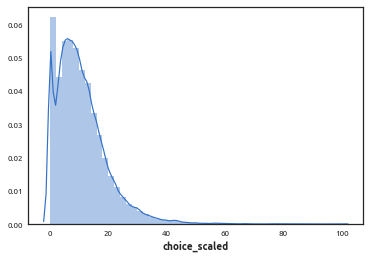

In [28]:
sns.distplot(joined_GSV_trees['choice_scaled'])

In [29]:
road_aggregated = {'osmid':[] , 'geometry' : [], 'green_gsv':[] , 'choice':[] }
for name , group in joined_GSV_trees.groupby('osmid'):
    road_aggregated['osmid'].append(name)
    road_aggregated['geometry'].append(group.iloc[0]['road_centroid'])
    road_aggregated['green_gsv'].append(np.mean(group['treePercent']))
    road_aggregated['choice'].append(group.iloc[0]['choice_scaled'])

road_aggregated_df = pd.DataFrame.from_dict(road_aggregated)
min_green = min(road_aggregated_df['green_gsv'])
max_green = max(road_aggregated_df['green_gsv'])
road_aggregated_df['green_gsv_scaled'] = road_aggregated_df['green_gsv'].apply(lambda x:((x - min_green)/(max_green-min_green))*100.0)
road_aggregated_df['green_random'] =  np.random.permutation(road_aggregated_df['green_gsv_scaled'].values)

road_aggregated_gpd = gpd.GeoDataFrame(road_aggregated_df, geometry='geometry', crs={'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'})

In [30]:

# for k in road_aggregated.keys():
#     print(k , len(road_aggregated[k]))

In [31]:
wards_shape = gpd.read_file('../Data/Geo_Data/wards_london_2016/London-wards-2018_ESRI/London_Ward.shp')

In [32]:
wards_shape = wards_shape.to_crs({'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'})

/work/sagarj/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


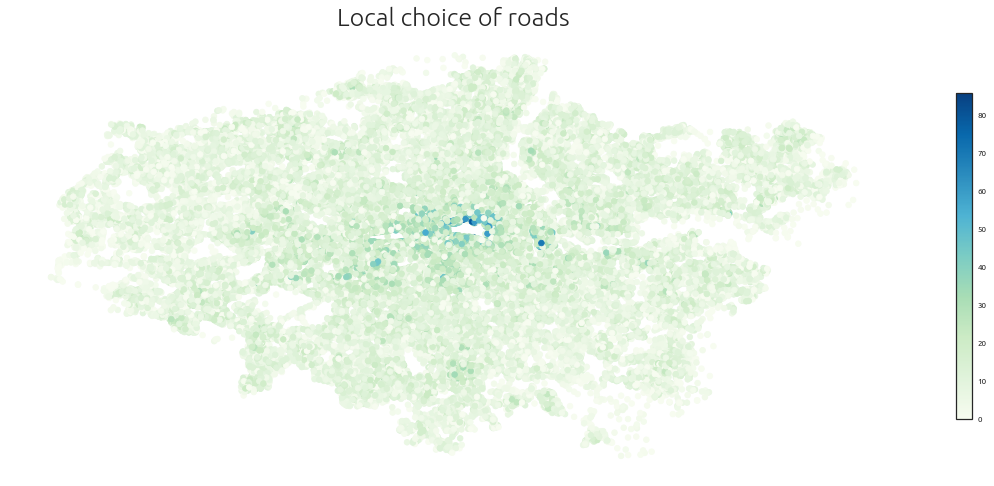

In [33]:
# road_aggregated_gpd.head(n=5)
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.axis('off')
ax.set_title('Local choice of roads', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=road_aggregated_gpd['choice'].min(), vmax=road_aggregated_gpd['choice'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
road_aggregated_gpd.plot(ax=ax,column='choice', cmap='GnBu', linewidth=0.8)

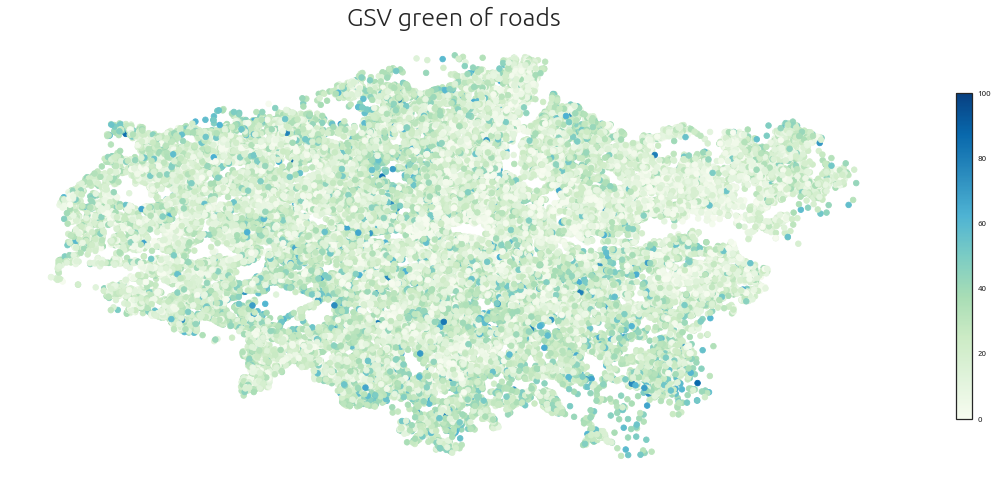

In [34]:
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.axis('off')
ax.set_title('GSV green of roads', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=road_aggregated_gpd['green_gsv_scaled'].min(), vmax=road_aggregated_gpd['green_gsv_scaled'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
road_aggregated_gpd.plot(ax=ax,column='green_gsv_scaled', cmap='GnBu', linewidth=0.8)

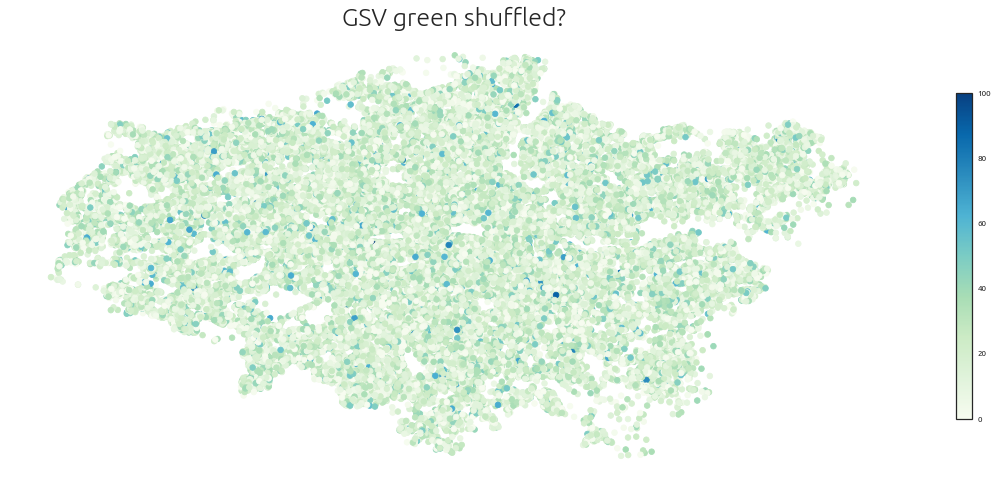

In [35]:
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.axis('off')
ax.set_title('GSV green shuffled?', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=road_aggregated_gpd['green_random'].min(), vmax=road_aggregated_gpd['green_random'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
road_aggregated_gpd.plot(ax=ax,column='green_random', cmap='GnBu', linewidth=0.8)

In [36]:
wards_shape.head(n=5)

NAME   GSS_CODE              DISTRICT  LAGSSCODE  \
0       Chessington South  E05000405  Kingston upon Thames  E09000021   
1  Tolworth and Hook Rise  E05000414  Kingston upon Thames  E09000021   
2              Berrylands  E05000401  Kingston upon Thames  E09000021   
3               Alexandra  E05000400  Kingston upon Thames  E09000021   
4                Beverley  E05000402  Kingston upon Thames  E09000021   

   HECTARES  NONLD_AREA                                           geometry  
0   755.173         0.0  POLYGON ((-0.33068 51.32901, -0.33059 51.32909...  
1   259.464         0.0  POLYGON ((-0.28409 51.36515, -0.28473 51.36541...  
2   145.390         0.0  POLYGON ((-0.30385 51.39249, -0.30375 51.39252...  
3   268.506         0.0  POLYGON ((-0.27257 51.37227, -0.27263 51.37228...  
4   187.821         0.0  POLYGON ((-0.25873 51.40956, -0.25869 51.40955...

In [37]:
joined_road_wards = sjoin(wards_shape,road_aggregated_gpd,how='left')

joined_road_wards= joined_road_wards[joined_road_wards['choice'].notna()]

In [38]:
joined_road_wards.head(n=5)

NAME   GSS_CODE              DISTRICT  LAGSSCODE  HECTARES  \
0  Chessington South  E05000405  Kingston upon Thames  E09000021   755.173   
0  Chessington South  E05000405  Kingston upon Thames  E09000021   755.173   
0  Chessington South  E05000405  Kingston upon Thames  E09000021   755.173   
0  Chessington South  E05000405  Kingston upon Thames  E09000021   755.173   
0  Chessington South  E05000405  Kingston upon Thames  E09000021   755.173   

   NONLD_AREA                                           geometry  index_right  \
0         0.0  POLYGON ((-0.33068 51.32901, -0.33059 51.32909...       8978.0   
0         0.0  POLYGON ((-0.33068 51.32901, -0.33059 51.32909...      10440.0   
0         0.0  POLYGON ((-0.33068 51.32901, -0.33059 51.32909...      10441.0   
0         0.0  POLYGON ((-0.33068 51.32901, -0.33059 51.32909...      34475.0   
0         0.0  POLYGON ((-0.33068 51.32901, -0.33059 51.32909...      41287.0   

                             osmid  green_gsv    choice  green_gsv_scaled  \
0                        224801816   0.010506  6.234498          2.704857   
0                         23054564   0.027564  5.852661          7.096245   
0                         23054611   0.034575  9.433333          8.901289   
0                         69146059   0.049627  3.209832         12.776371   
0  [175872776, 220771987, 2953612]   0.118918  0.926856         30.615316   

   green_random  
0     18.188319  
0     36.819130  
0     34.572408  
0     14.138856  
0      1.376341

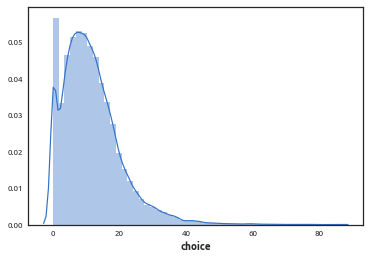

In [39]:
sns.distplot(joined_road_wards['choice'])

In [40]:
gsv_ward_aggregated = {'GSS_CODE':[] , 'NAME' : [], 'geometry':[] , 'green_gsv':[] , 'green_gsv_null' : [] , 'green_gsv_unweighted'  : [] , 'mean_choice' : [] , 'median_choice': [] , 'std_choice': []}
for name , group in joined_road_wards.groupby('GSS_CODE'):
    gsv_ward_aggregated['GSS_CODE'].append(name)
    gsv_ward_aggregated['geometry'].append(group.iloc[0]['geometry'])
    numerator = sum(group['green_gsv_scaled']*group['choice'])
    numerator_null = sum(group['green_random']*group['choice'])
    denom = sum(group['choice'])
    gsv_ward_aggregated['green_gsv'].append(numerator/denom)
    gsv_ward_aggregated['mean_choice'].append(np.mean(group['choice']))
    gsv_ward_aggregated['median_choice'].append(np.median(group['choice']))
    gsv_ward_aggregated['std_choice'].append(np.std(group['choice']))
    gsv_ward_aggregated['green_gsv_null'].append(numerator_null/denom)
    gsv_ward_aggregated['green_gsv_unweighted'].append(np.mean(group['green_gsv_scaled']))
    gsv_ward_aggregated['NAME'].append(group.iloc[0]['NAME'])
gsv_ward_aggregated_df = pd.DataFrame.from_dict(gsv_ward_aggregated)
gsv_ward_aggregated_gpd = gpd.GeoDataFrame(gsv_ward_aggregated_df, geometry='geometry', crs={'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'})

In [41]:
gsv_ward_aggregated_gpd.head(n=5)

GSS_CODE            NAME  \
0  E05000026           Abbey   
1  E05000027          Alibon   
2  E05000028       Becontree   
3  E05000029  Chadwell Heath   
4  E05000030       Eastbrook   

                                            geometry  green_gsv  \
0  POLYGON ((0.08548 51.53704, 0.08535 51.53693, ...  10.238276   
1  POLYGON ((0.13190 51.54376, 0.13208 51.54383, ...   9.982875   
2  POLYGON ((0.10743 51.55200, 0.10757 51.55204, ...  10.493734   
3  POLYGON ((0.14698 51.57568, 0.14654 51.57566, ...  16.473316   
4  POLYGON ((0.16157 51.54333, 0.16156 51.54378, ...   9.060214   

   green_gsv_null  green_gsv_unweighted  mean_choice  median_choice  \
0       19.591897             10.687261    14.176203      13.855123   
1       21.412217             10.269987     9.614580       8.563932   
2       17.748192             11.220406    12.623284      13.285051   
3       14.416902             16.415619     8.776464       9.297543   
4       17.135903              9.635628     7.141968       7.007301   

   std_choice  
0    5.704466  
1    4.634217  
2    6.332820  
3    5.033655  
4    5.072869

In [42]:
gsv_ward_aggregated_reproj = gsv_ward_aggregated_gpd.to_crs({'init': 'epsg:27700'})

/work/sagarj/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


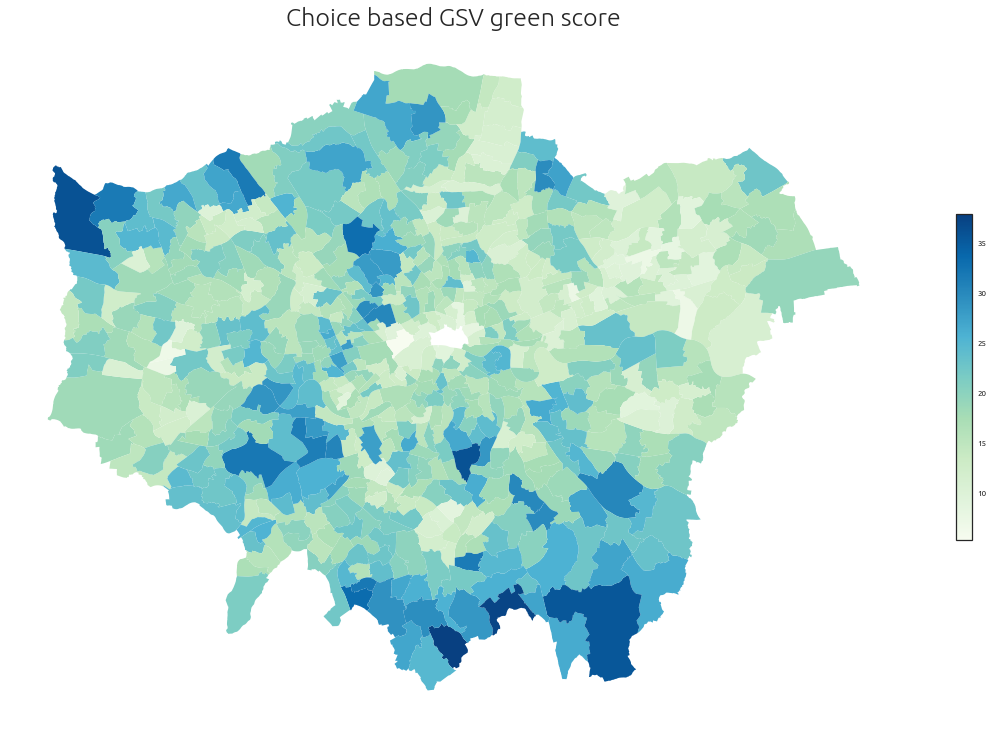

In [43]:
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.axis('off')
ax.set_title('Choice based GSV green score', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=gsv_ward_aggregated_reproj['green_gsv'].min(), vmax=gsv_ward_aggregated_gpd['green_gsv'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
gsv_ward_aggregated_reproj.plot(ax=ax,column='green_gsv', cmap='GnBu', linewidth=0.8)

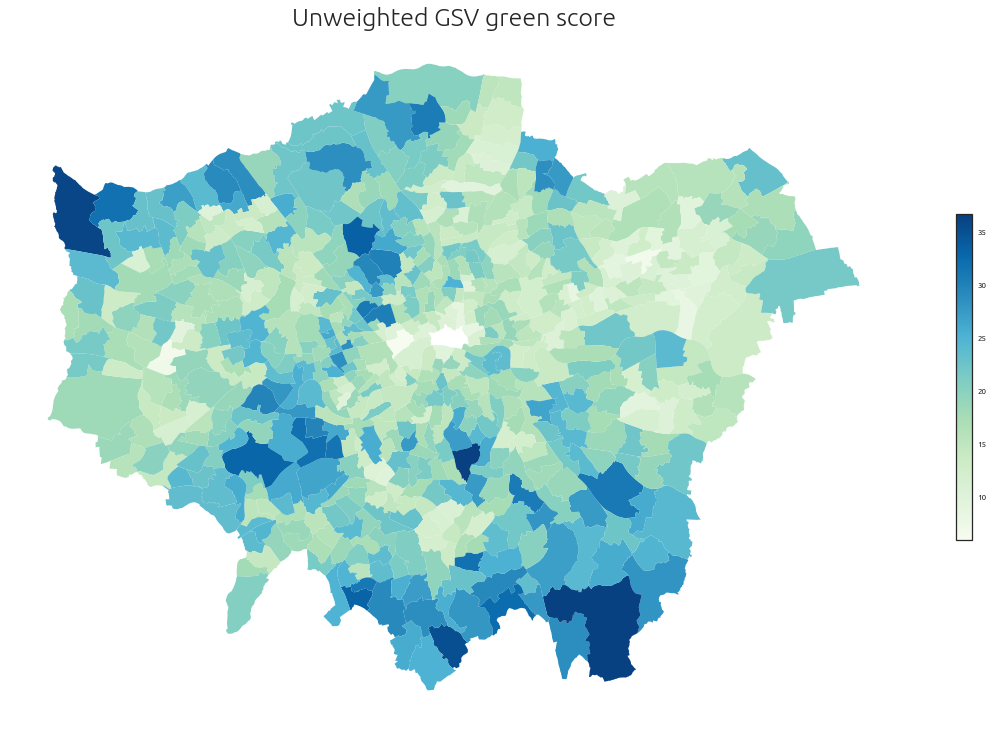

In [44]:
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.axis('off')
ax.set_title('Unweighted GSV green score', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=gsv_ward_aggregated_reproj['green_gsv_unweighted'].min(), vmax=gsv_ward_aggregated_gpd['green_gsv_unweighted'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
gsv_ward_aggregated_reproj.plot(ax=ax,column='green_gsv_unweighted', cmap='GnBu', linewidth=0.8)

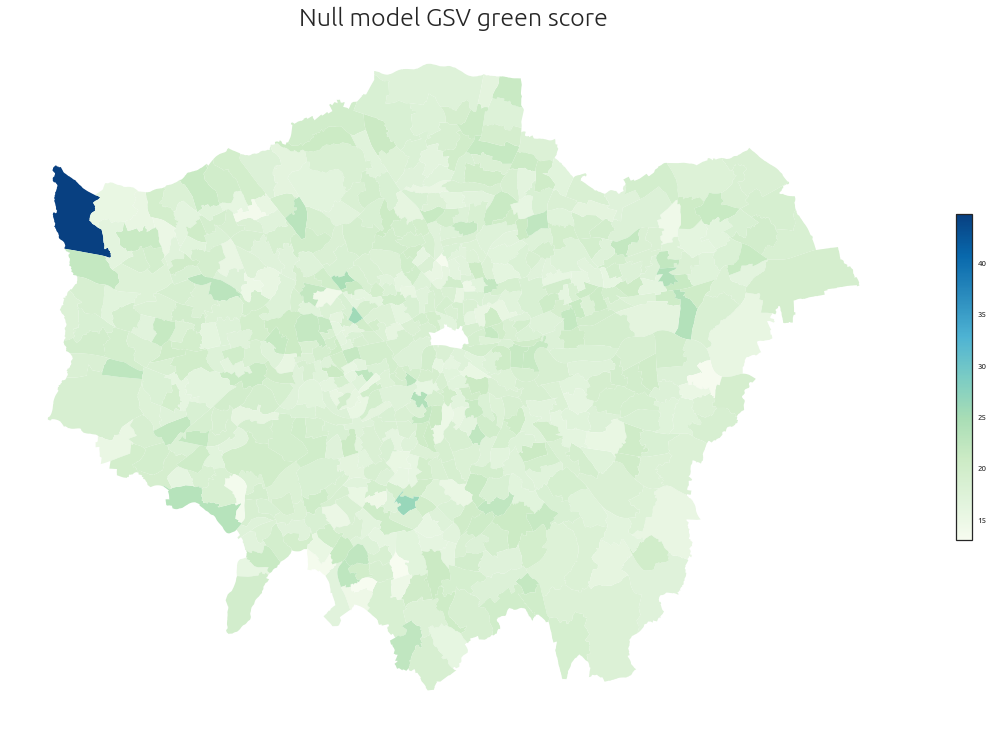

In [45]:
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.axis('off')
ax.set_title('Null model GSV green score', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=gsv_ward_aggregated_reproj['green_gsv_null'].min(), vmax=gsv_ward_aggregated_gpd['green_gsv_null'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
gsv_ward_aggregated_reproj.plot(ax=ax,column='green_gsv_null', cmap='GnBu', linewidth=0.8)

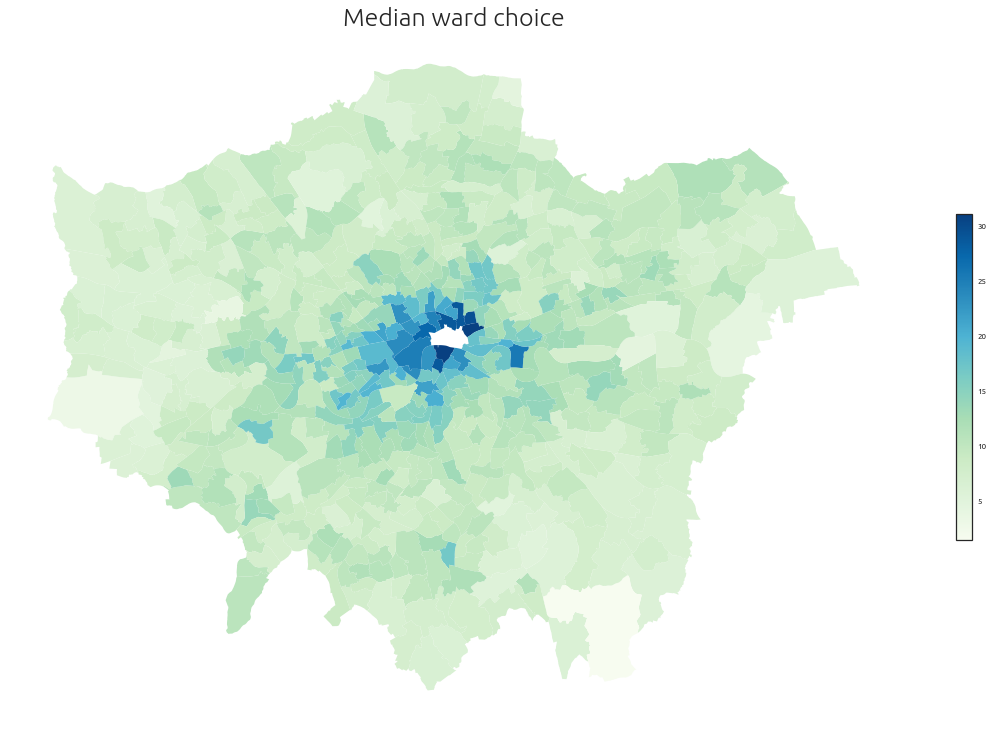

In [46]:
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.axis('off')
ax.set_title('Median ward choice', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=gsv_ward_aggregated_reproj['median_choice'].min(), vmax=gsv_ward_aggregated_gpd['median_choice'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
gsv_ward_aggregated_reproj.plot(ax=ax,column='median_choice', cmap='GnBu', linewidth=0.8)

In [47]:
len(joined_road_wards)

49483

In [48]:
satellite_green = pd.read_csv('scratchpad/SAT_greenery_per_segment.csv')

In [49]:
satellite_green.head()

Unnamed: 0      osmid  sat_green_area  sat_green_pct  segment_tot_area
0           0  100076118       90.917383       0.043730       2079.067103
1           1  100076137     1870.298240       0.313623       5963.514822
2           2  100076140     7846.994381       0.393731      19929.850956
3           3  100076150       28.874368       0.046160        625.533164
4           4  100076152      793.291016       0.122778       6461.192078

In [50]:
min_sat = min(satellite_green['sat_green_pct'])
max_sat = max(satellite_green['sat_green_pct'])

satellite_green['sat_green_scaled'] = satellite_green['sat_green_pct'].apply(lambda x:((x - min_sat)/(max_sat-min_sat))*100.0)
satellite_green['sat_green_null'] = 0
satellite_green['sat_green_null'] = np.random.permutation(satellite_green['sat_green_scaled'].values)


In [51]:
len(satellite_green)

98868

In [52]:
joined_SAT_trees = pd.merge(roads_WGS84 , satellite_green,left_on='osmid' , right_on='osmid', how='inner')

In [53]:
len(joined_SAT_trees)

187202

In [54]:
joined_SAT_trees.head(n=5)

osmid                                           geometry  LogChR800  \
0  204647020  POLYGON ((-0.15275 51.52352, -0.15277 51.52352...   3.905958   
1  204647020  POLYGON ((-0.15275 51.52352, -0.15277 51.52352...   3.030195   
2  233623258  POLYGON ((-0.15308 51.52393, -0.15308 51.52394...   3.905958   
3   19796012  POLYGON ((-0.15806 51.52468, -0.15802 51.52466...   3.905958   
4   19796012  POLYGON ((-0.15806 51.52468, -0.15802 51.52466...   3.015779   

   area  Unnamed: 0  sat_green_area  sat_green_pct  segment_tot_area  \
0  None       16731       19.649376       0.041350        475.195801   
1  None       16731       19.649376       0.041350        475.195801   
2  None       23839       47.116444       0.037721       1249.079411   
3  None       15777     1926.383081       0.230323       8363.849381   
4  None       15777     1926.383081       0.230323       8363.849381   

   sat_green_scaled  sat_green_null  
0          4.135006       51.395328  
1          4.135006       51.395328  
2          3.772093       23.511490  
3         23.032254       24.180952  
4         23.032254       24.180952

In [55]:
joined_SAT_trees = joined_SAT_trees.drop_duplicates(subset=['osmid'])
len(joined_SAT_trees)

75906

In [56]:
joined_SAT_trees.head(n=5)

osmid                                           geometry  LogChR800  \
0  204647020  POLYGON ((-0.15275 51.52352, -0.15277 51.52352...   3.905958   
2  233623258  POLYGON ((-0.15308 51.52393, -0.15308 51.52394...   3.905958   
3   19796012  POLYGON ((-0.15806 51.52468, -0.15802 51.52466...   3.905958   
6  292570593  POLYGON ((-0.14955 51.52470, -0.14954 51.52470...   3.030195   
8  204647015  POLYGON ((-0.15274 51.52404, -0.15273 51.52403...   3.030195   

   area  Unnamed: 0  sat_green_area  sat_green_pct  segment_tot_area  \
0  None       16731       19.649376       0.041350        475.195801   
2  None       23839       47.116444       0.037721       1249.079411   
3  None       15777     1926.383081       0.230323       8363.849381   
6  None       31854     2487.382010       0.476548       5219.587666   
8  None       16729       99.786278       0.079599       1253.604707   

   sat_green_scaled  sat_green_null  
0          4.135006       51.395328  
2          3.772093       23.511490  
3         23.032254       24.180952  
6         47.654760        8.846245  
8          7.959947       60.137332

In [57]:
joined_SAT_trees = joined_SAT_trees[joined_SAT_trees['osmid'].notna()]
joined_SAT_trees = joined_SAT_trees[joined_SAT_trees['sat_green_scaled'].notna()]

joined_SAT_trees['road_centroid'] = joined_SAT_trees['geometry'].centroid

joined_SAT_trees['choice'] = joined_SAT_trees['LogChR800'].apply(lambda x : np.exp(x))
min_choice = min(joined_SAT_trees['choice'])
max_choice = max(joined_SAT_trees['choice'])

joined_SAT_trees['choice_scaled'] = joined_SAT_trees['choice'].apply(lambda x:((x - min_choice)/(max_choice-min_choice))*100.0)

In [58]:
len(joined_SAT_trees['osmid'].unique()) , len(joined_SAT_trees)

(75906, 75906)

In [59]:
joined_SAT_trees.head(n=5)

osmid                                           geometry  LogChR800  \
0  204647020  POLYGON ((-0.15275 51.52352, -0.15277 51.52352...   3.905958   
2  233623258  POLYGON ((-0.15308 51.52393, -0.15308 51.52394...   3.905958   
3   19796012  POLYGON ((-0.15806 51.52468, -0.15802 51.52466...   3.905958   
6  292570593  POLYGON ((-0.14955 51.52470, -0.14954 51.52470...   3.030195   
8  204647015  POLYGON ((-0.15274 51.52404, -0.15273 51.52403...   3.030195   

   area  Unnamed: 0  sat_green_area  sat_green_pct  segment_tot_area  \
0  None       16731       19.649376       0.041350        475.195801   
2  None       23839       47.116444       0.037721       1249.079411   
3  None       15777     1926.383081       0.230323       8363.849381   
6  None       31854     2487.382010       0.476548       5219.587666   
8  None       16729       99.786278       0.079599       1253.604707   

   sat_green_scaled  sat_green_null              road_centroid     choice  \
0          4.135006       51.395328  POINT (-0.15273 51.52362)  49.697653   
2          3.772093       23.511490  POINT (-0.15287 51.52381)  49.697653   
3         23.032254       24.180952  POINT (-0.15563 51.52397)  49.697653   
6         47.654760        8.846245  POINT (-0.15122 51.52432)  20.701265   
8          7.959947       60.137332  POINT (-0.15278 51.52383)  20.701265   

   choice_scaled  
0      35.194399  
2      35.194399  
3      35.194399  
6      14.086097  
8      14.086097

In [60]:
road_SAT_aggregated = joined_SAT_trees[['road_centroid','sat_green_scaled','sat_green_null','choice_scaled','osmid']].copy()
road_SAT_aggregated_gpd = gpd.GeoDataFrame(road_SAT_aggregated, geometry='road_centroid', crs={'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'})

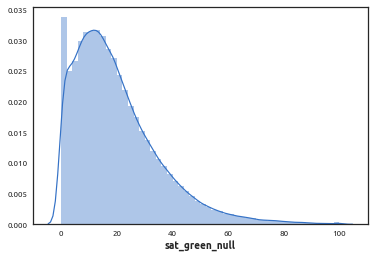

In [61]:
sns.distplot(road_SAT_aggregated_gpd['sat_green_null'])

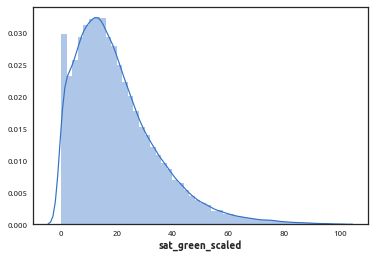

In [62]:
sns.distplot(road_SAT_aggregated_gpd['sat_green_scaled'])

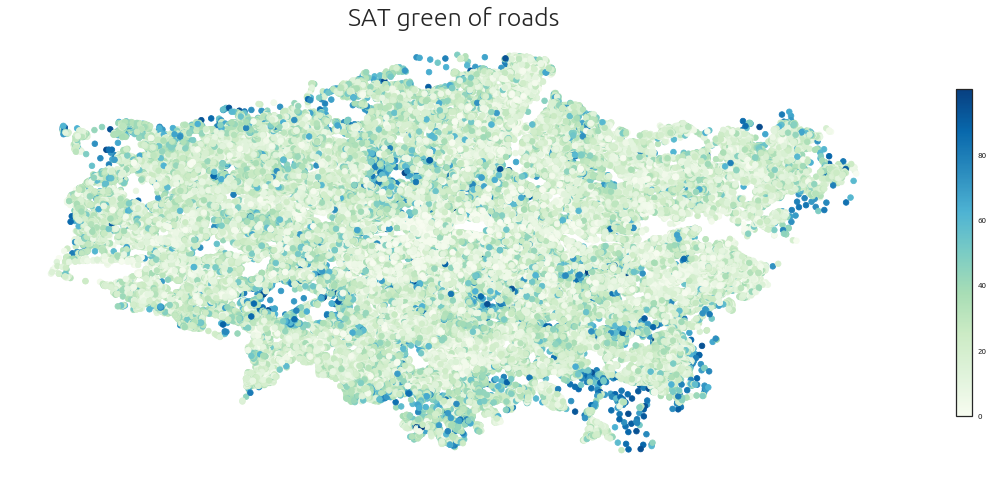

In [63]:
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.axis('off')
ax.set_title('SAT green of roads', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=road_SAT_aggregated_gpd['sat_green_scaled'].min(), vmax=road_SAT_aggregated_gpd['sat_green_scaled'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
road_SAT_aggregated_gpd.plot(ax=ax,column='sat_green_scaled', cmap='GnBu', linewidth=0.8)

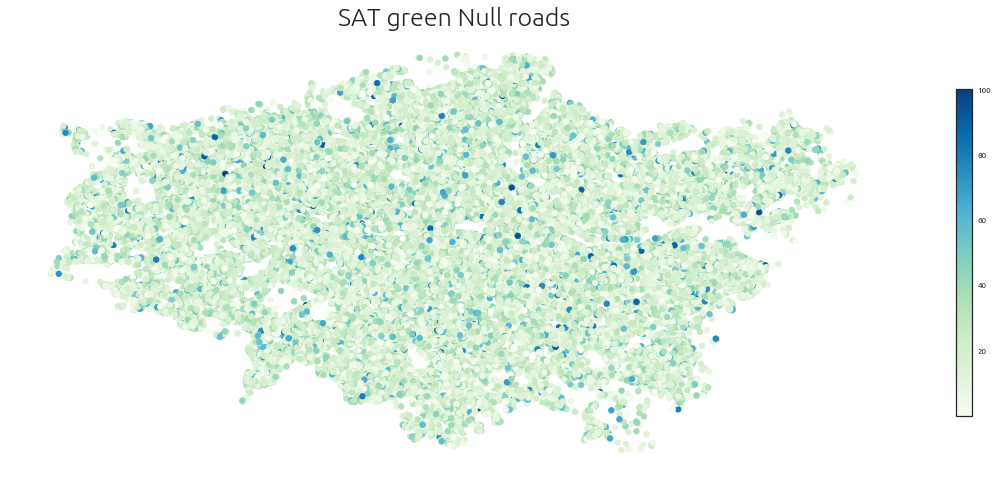

In [64]:
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.axis('off')
ax.set_title('SAT green Null roads', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=road_SAT_aggregated_gpd['sat_green_null'].min(), vmax=road_SAT_aggregated_gpd['sat_green_null'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
road_SAT_aggregated_gpd.plot(ax=ax,column='sat_green_null', cmap='GnBu', linewidth=0.8)

In [65]:
joined_sat_road_wards = sjoin(wards_shape,road_SAT_aggregated_gpd,how='left')

joined_sat_road_wards= joined_sat_road_wards[joined_sat_road_wards['choice_scaled'].notna()]

joined_sat_road_wards.head(n=5)

NAME   GSS_CODE              DISTRICT  LAGSSCODE  HECTARES  \
0  Chessington South  E05000405  Kingston upon Thames  E09000021   755.173   
0  Chessington South  E05000405  Kingston upon Thames  E09000021   755.173   
0  Chessington South  E05000405  Kingston upon Thames  E09000021   755.173   
0  Chessington South  E05000405  Kingston upon Thames  E09000021   755.173   
0  Chessington South  E05000405  Kingston upon Thames  E09000021   755.173   

   NONLD_AREA                                           geometry  index_right  \
0         0.0  POLYGON ((-0.33068 51.32901, -0.33059 51.32909...     160179.0   
0         0.0  POLYGON ((-0.33068 51.32901, -0.33059 51.32909...     162429.0   
0         0.0  POLYGON ((-0.33068 51.32901, -0.33059 51.32909...      24605.0   
0         0.0  POLYGON ((-0.33068 51.32901, -0.33059 51.32909...      24611.0   
0         0.0  POLYGON ((-0.33068 51.32901, -0.33059 51.32909...     159164.0   

   sat_green_scaled  sat_green_null  choice_scaled      osmid  
0         13.028177       17.456242       5.702095  161636078  
0         15.944775        9.189140      15.114575  161415777  
0         14.326146       15.962607      19.890688  154532354  
0         17.393054        9.880262      19.890688  154532353  
0          6.817382       39.880856       0.000000   19822697

In [66]:
sat_ward_aggregated = {'GSS_CODE':[] , 'NAME' : [], 'geometry':[] , 'green_sat':[] , 'green_sat_null': [] , 'green_sat_unweighted' : [] , 'ward_choice':[]}
for name , group in joined_sat_road_wards.groupby('GSS_CODE'):
    sat_ward_aggregated['GSS_CODE'].append(name)
    sat_ward_aggregated['geometry'].append(group.iloc[0]['geometry'])
    numerator = sum(group['sat_green_scaled']*group['choice_scaled'])
    numerator_null = sum(group['sat_green_null']*group['choice_scaled'])
    denom = sum(group['choice_scaled'])
    sat_ward_aggregated['green_sat'].append(numerator/denom)
    sat_ward_aggregated['green_sat_null'].append(numerator_null/denom)
    sat_ward_aggregated['green_sat_unweighted'].append(np.mean(group['sat_green_scaled']))
    sat_ward_aggregated['ward_choice'].append(np.mean(group['choice_scaled']))
    sat_ward_aggregated['NAME'].append(group.iloc[0]['NAME'])
sat_ward_aggregated_df = pd.DataFrame.from_dict(sat_ward_aggregated)
sat_ward_aggregated_gpd = gpd.GeoDataFrame(sat_ward_aggregated_df, geometry='geometry', crs={'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'})

In [67]:
sat_ward_aggregated_reproj = sat_ward_aggregated_gpd.to_crs({'init': 'epsg:27700'})

/work/sagarj/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


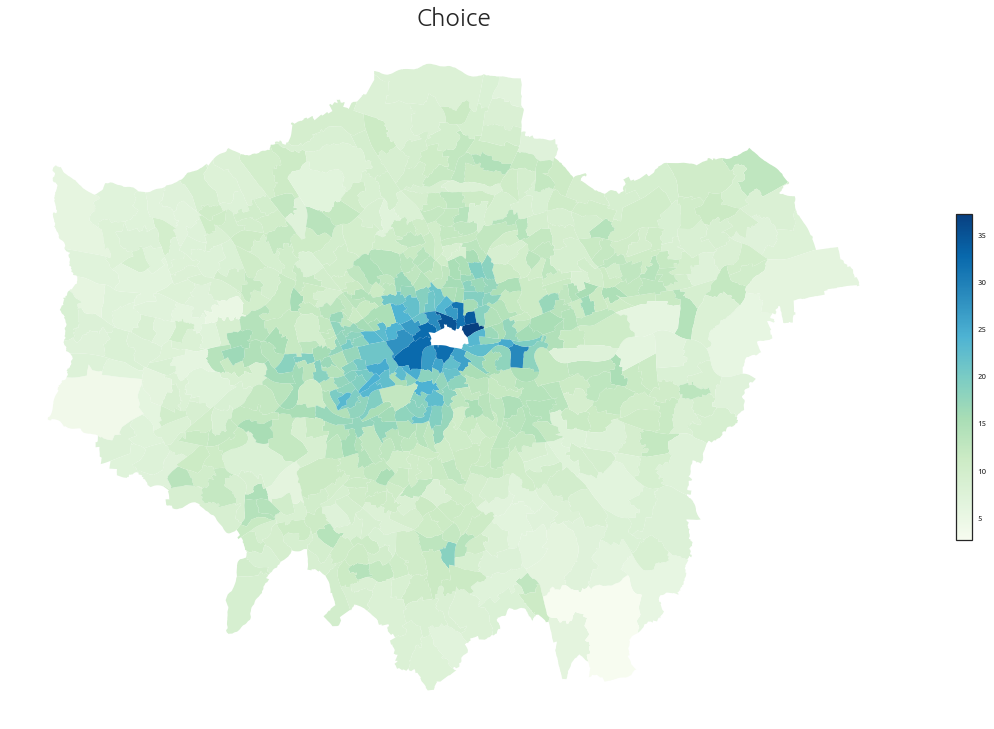

In [68]:
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.axis('off')
ax.set_title('Choice', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=sat_ward_aggregated_reproj['ward_choice'].min(), vmax=sat_ward_aggregated_reproj['ward_choice'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
sat_ward_aggregated_reproj.plot(ax=ax,column='ward_choice', cmap='GnBu', linewidth=0.8)

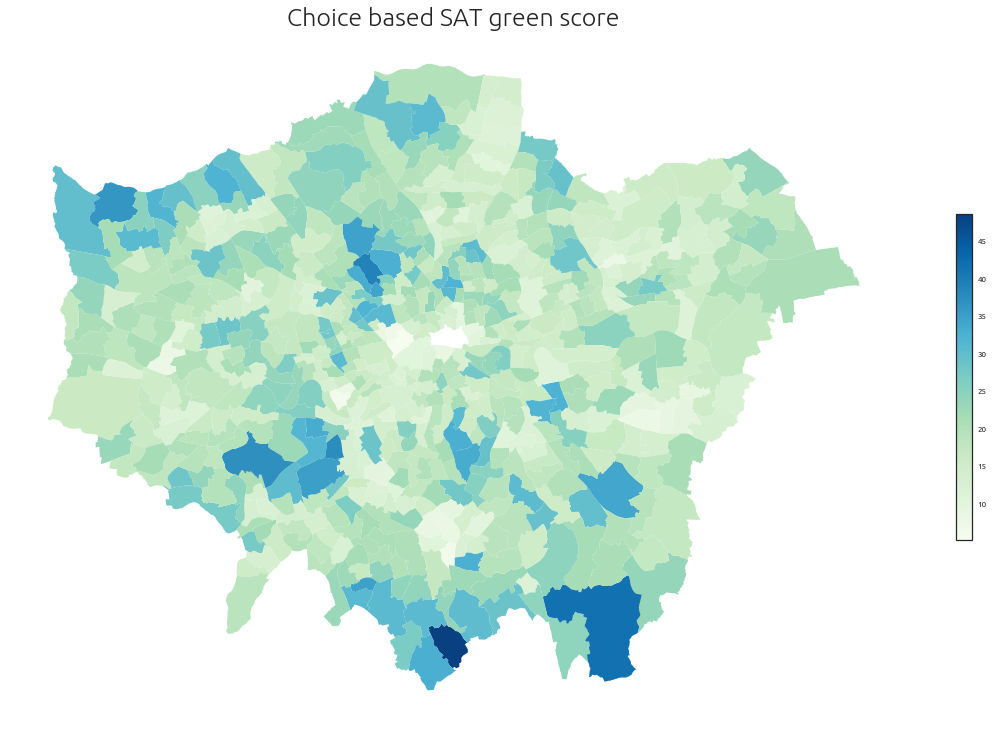

In [69]:
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.axis('off')
ax.set_title('Choice based SAT green score', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=sat_ward_aggregated_reproj['green_sat'].min(), vmax=sat_ward_aggregated_reproj['green_sat'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
sat_ward_aggregated_reproj.plot(ax=ax,column='green_sat', cmap='GnBu', linewidth=0.8)

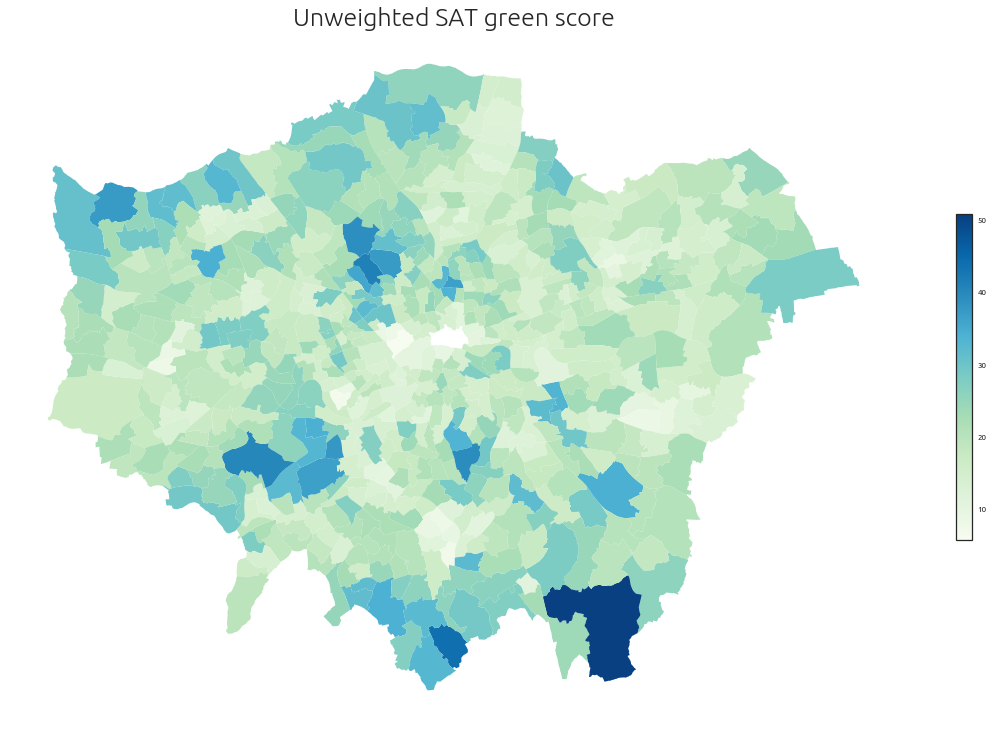

In [70]:
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.axis('off')
ax.set_title('Unweighted SAT green score', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=sat_ward_aggregated_reproj['green_sat_unweighted'].min(), vmax=sat_ward_aggregated_reproj['green_sat_unweighted'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
sat_ward_aggregated_reproj.plot(ax=ax,column='green_sat_unweighted', cmap='GnBu', linewidth=0.8)

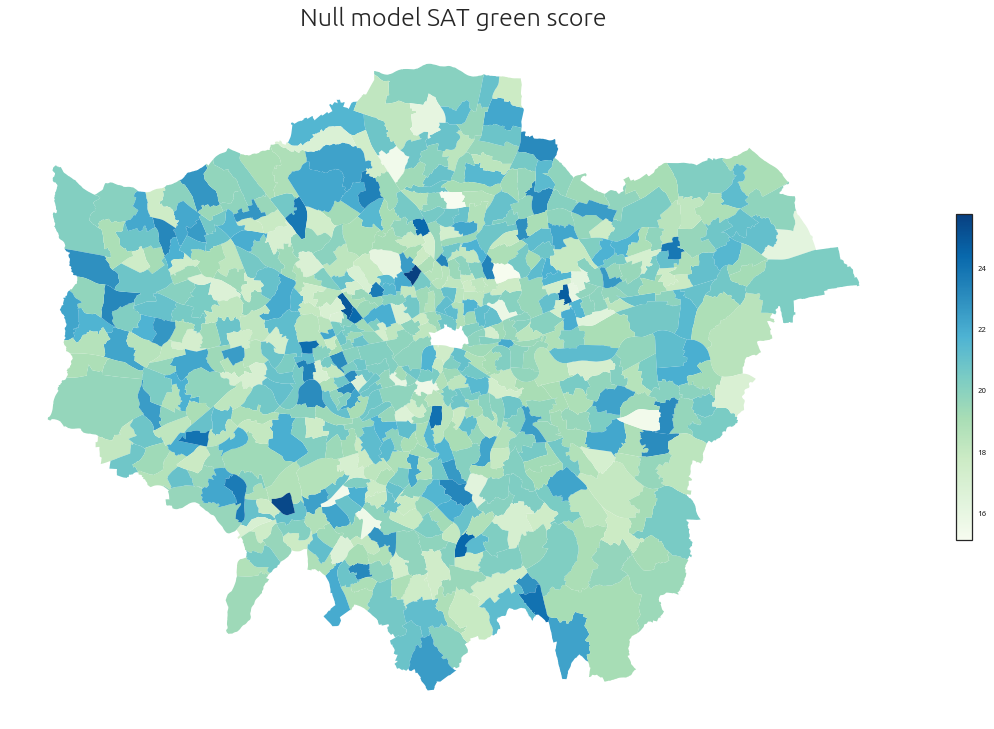

In [71]:
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.axis('off')
ax.set_title('Null model SAT green score', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=sat_ward_aggregated_reproj['green_sat_null'].min(), vmax=sat_ward_aggregated_reproj['green_sat_null'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
sat_ward_aggregated_reproj.plot(ax=ax,column='green_sat_null', cmap='GnBu', linewidth=0.8)

In [72]:
# sat_ward_aggregated_reproj.to_file("Choice_Green_scores/London_choice_sat_green_score.shp")
# gsv_ward_aggregated_reproj.to_file("Choice_Green_scores/London_choice_gsv_green_score.shp")

In [73]:
sat_ward_aggregated_reproj.head(n=2)

GSS_CODE    NAME                                           geometry  \
0  E05000026   Abbey  POLYGON ((544735.197 184076.498, 544726.597 18...   
1  E05000027  Alibon  POLYGON ((547932.401 184916.597, 547944.801 18...   

   green_sat  green_sat_null  green_sat_unweighted  ward_choice  
0  12.061087       19.688896             12.963320    14.943529  
1  18.792613       17.834659             21.693588     9.776822

In [74]:
gsv_ward_aggregated_reproj.head(n=2)

GSS_CODE    NAME                                           geometry  \
0  E05000026   Abbey  POLYGON ((544735.197 184076.498, 544726.597 18...   
1  E05000027  Alibon  POLYGON ((547932.401 184916.597, 547944.801 18...   

   green_gsv  green_gsv_null  green_gsv_unweighted  mean_choice  \
0  10.238276       19.591897             10.687261    14.176203   
1   9.982875       21.412217             10.269987     9.614580   

   median_choice  std_choice  
0      13.855123    5.704466  
1       8.563932    4.634217

In [75]:
green_sat_sub = sat_ward_aggregated_reproj[['GSS_CODE','green_sat','green_sat_null','green_sat_unweighted']].copy()
overall_green = pd.merge(gsv_ward_aggregated_reproj,green_sat_sub, left_on='GSS_CODE' , right_on='GSS_CODE')

In [76]:
overall_green.head(n=2)

GSS_CODE    NAME                                           geometry  \
0  E05000026   Abbey  POLYGON ((544735.197 184076.498, 544726.597 18...   
1  E05000027  Alibon  POLYGON ((547932.401 184916.597, 547944.801 18...   

   green_gsv  green_gsv_null  green_gsv_unweighted  mean_choice  \
0  10.238276       19.591897             10.687261    14.176203   
1   9.982875       21.412217             10.269987     9.614580   

   median_choice  std_choice  green_sat  green_sat_null  green_sat_unweighted  
0      13.855123    5.704466  12.061087       19.688896             12.963320  
1       8.563932    4.634217  18.792613       17.834659             21.693588

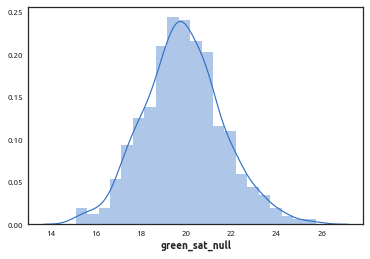

In [77]:
sns.distplot(overall_green['green_sat_null'])

In [78]:
# overall_green.to_file("Choice_Green_scores/London_choice_green_scores.shp")

In [79]:
import json
diseases  = json.load(open('../Data/health_data/timeSeries_data/prevalence_disease_timeseries.json','rb'))

In [80]:
def getDiseaase_frame(disease_dict , month ,diseaseName):
    if month in disease_dict:
        dictionary1 = disease_dict[month]['Ward_Prescriptions'][diseaseName]
        dictionary2 = disease_dict[month]['Ward_Prevalence'][diseaseName]
        data = {'GSS_CODE':[] , 'Prescriptions' : [] , 'Prevalence':[]}
        for k in dictionary2:
            data['GSS_CODE'].append(k)
            data['Prescriptions'].append(dictionary1[k])
            data['Prevalence'].append(dictionary2[k])
        dataframe = pd.DataFrame.from_dict(data)
        return dataframe

In [81]:
depression = getDiseaase_frame(diseases, '201610' , 'depression')

In [82]:
data = pd.read_csv('Solo_living/All_data_aggregated_ward_level.csv')

In [83]:
list(data.columns)

['Unnamed: 0',
 'Unnamed: 0.1',
 'green_score',
 'GSS_CODE',
 'WD17CD',
 'GLUD_Area of Greenspace PCT',
 'LCM_grass_pct',
 'LCM_tree_pct',
 'LCM_urban_pct',
 'UA_Public Greenery PCT',
 'UA_Forests PCT',
 'StreetTrees_PCT',
 'Unnamed: 0.1.1',
 'borough_name_x',
 'poly',
 'area_m',
 'area_km',
 'gsview_point_list',
 'gsview_segnet_tags_dict',
 'gsview_tags',
 'total_gsview_pixels',
 'Tree',
 'TreeTotal',
 'TreeScore',
 'psoriasis_Prescriptions',
 'psoriasis_Prevalence',
 "Meniere's disease_Prescriptions",
 "Meniere's disease_Prevalence",
 "crohn's disease_Prescriptions",
 "crohn's disease_Prevalence",
 'gastroparesis_Prescriptions',
 'gastroparesis_Prevalence',
 'irritable bowel syndrome_Prescriptions',
 'irritable bowel syndrome_Prevalence',
 'parkinson_Prescriptions',
 'parkinson_Prevalence',
 'sleep apnea_Prescriptions',
 'sleep apnea_Prevalence',
 'interstitial cystitis_Prescriptions',
 'interstitial cystitis_Prevalence',
 'bipolar_Prescriptions',
 'bipolar_Prevalence',
 'hypothyroid

In [84]:
ward_data = pd.read_csv('scratchpad/london_ward_imd_measures.csv')

In [85]:
ward_sat_green_all = pd.read_csv('scratchpad/london_sat_ward_green_all.csv')
ward_sat_green_all = ward_sat_green_all.rename(columns={"percent_green": "sat_all_ward_green"})

In [86]:
ward_sat_green_all.head(n=2)

ward_code  sat_all_ward_green
0  E05000026               27.84
1  E05000027               45.94

In [87]:
selected_aggregate_data= data[['GSS_CODE',
                          'Median 2012/13','depression_Prevalence',
                          'diabetes_Prevalence','Population_per_square_kilometre']].copy()

In [88]:
len(selected_aggregate_data)

424

In [89]:
ward_data.head(n=2)


Ward Code Ward Name               Borough  Population  \
0  E05000026     Abbey  Barking and Dagenham       14370   
1  E05000027    Alibon  Barking and Dagenham       10845   

   Working age population  Child population  16-59 population  \
0                    9403              3899              9397   
1                    6459              2865              6600   

   Old age population IMD Extent %  IMD Extent Rank  ...  Income rank  \
0                1074          43%               82  ...          111   
1                1380          65%               25  ...           58   

   Employment scale  Employment score  Employment rank  IDACI scale  \
0             870.6             0.093              252       915.40   
1             883.2             0.137               40       737.44   

  IDACI score IDACI score rank  IDAOPI scale  IDAOPI score  \
0       0.235              154        376.91         0.351   
1       0.257              112        379.34         0.275   

   IDAOPI score (rank)  
0                   99  
1                  199  

[2 rows x 34 columns]

In [90]:
print(ward_data.columns)

Index(['Ward Code', 'Ward Name', 'Borough', 'Population',
       'Working age population', 'Child population', '16-59 population',
       'Old age population', 'IMD Extent %', 'IMD Extent Rank',
       'IMD Average rank', 'IMD average rank rank', 'IMD average score',
       'IMD average score rank', 'Rank of worst LSOA', 'Worst LSOA Code',
       'Worst LSOA: % of resident in ward', 'Number of LSOAs',
       '# LSOAs in worst 5%', '# LSOAs in worst 10%', '# LSOAs in worst 20%',
       '# LSOAs in worst 50%', 'Income scale', 'Income score', 'Income rank',
       'Employment scale', 'Employment score', 'Employment rank',
       'IDACI scale', 'IDACI score', 'IDACI score rank', 'IDAOPI scale',
       'IDAOPI score', 'IDAOPI score (rank)'],
      dtype='object')


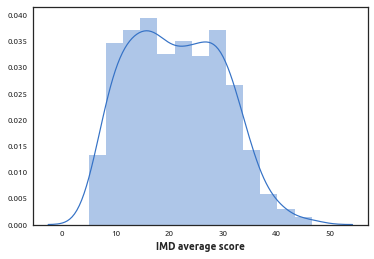

In [91]:
sns.distplot(ward_data['IMD average score'])

In [92]:
selected_ward_data= ward_data[['Ward Code',
                          'Population','Working age population',
                          'IMD average score']].copy()

In [93]:
print(len(selected_ward_data))

633


In [94]:
selected_ward_data = pd.merge(selected_ward_data,selected_aggregate_data, left_on='Ward Code' , right_on='GSS_CODE')

In [95]:
overall_green = pd.merge(overall_green,ward_sat_green_all, left_on='GSS_CODE' , right_on='ward_code')
print(len(overall_green))

632


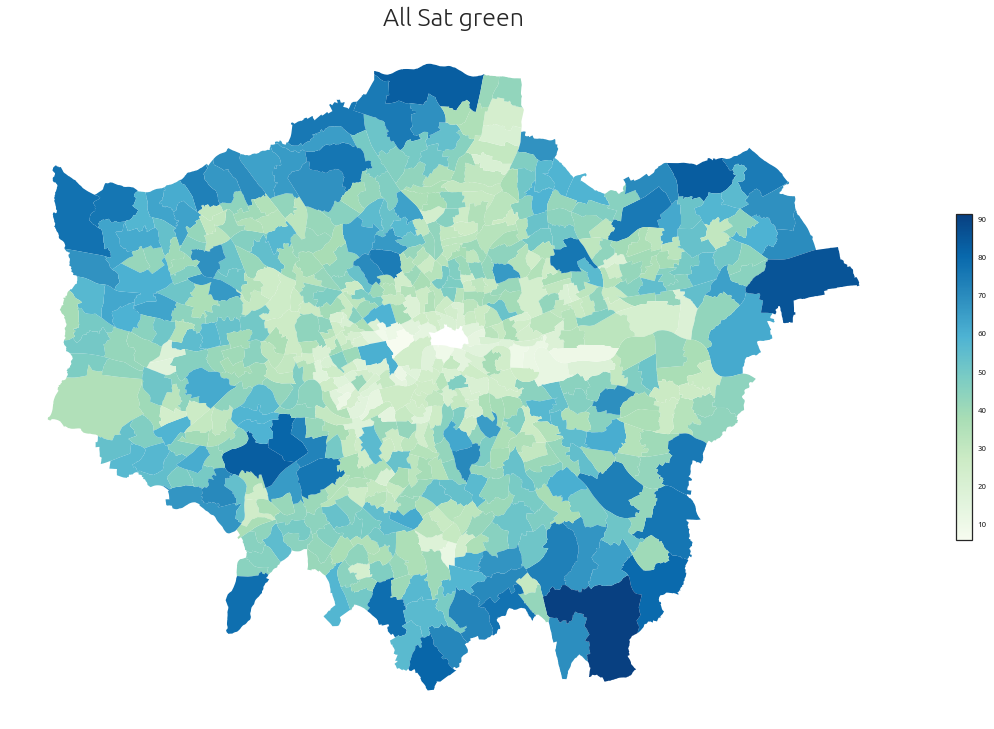

In [96]:
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.axis('off')
ax.set_title('All Sat green', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=overall_green['sat_all_ward_green'].min(), vmax=overall_green['sat_all_ward_green'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
overall_green.plot(ax=ax,column='sat_all_ward_green', cmap='GnBu', linewidth=0.8)

In [97]:
data_merge = pd.merge(overall_green,selected_ward_data, left_on='GSS_CODE' , right_on='Ward Code')

In [98]:
data_merge.corr()

green_gsv  green_gsv_null  \
green_gsv                         1.000000        0.018559   
green_gsv_null                    0.018559        1.000000   
green_gsv_unweighted              0.981787        0.007568   
mean_choice                      -0.242400       -0.027341   
median_choice                    -0.215668       -0.032743   
std_choice                       -0.250353       -0.080833   
green_sat                         0.821334        0.041155   
green_sat_null                    0.011934        0.017906   
green_sat_unweighted              0.807581        0.036644   
sat_all_ward_green                0.551383        0.050976   
Population                       -0.171717       -0.044020   
Working age population           -0.252251       -0.046864   
IMD average score                -0.400916        0.073970   
Median 2012/13                    0.362360       -0.073304   
depression_Prevalence             0.319091       -0.102025   
diabetes_Prevalence              -0.253949        0.032090   
Population_per_square_kilometre  -0.301797       -0.006789   

                                 green_gsv_unweighted  mean_choice  \
green_gsv                                    0.981787    -0.242400   
green_gsv_null                               0.007568    -0.027341   
green_gsv_unweighted                         1.000000    -0.245803   
mean_choice                                 -0.245803     1.000000   
median_choice                               -0.220552     0.977598   
std_choice                                  -0.248453     0.901690   
green_sat                                    0.813917    -0.236203   
green_sat_null                               0.002493    -0.060432   
green_sat_unweighted                         0.820719    -0.257473   
sat_all_ward_green                           0.572435    -0.532138   
Population                                  -0.166365    -0.022639   
Working age population                      -0.249637     0.210024   
IMD average score                           -0.421623     0.137607   
Median 2012/13                               0.371689     0.232685   
depression_Prevalence                        0.328064     0.080663   
diabetes_Prevalence                         -0.257138    -0.308788   
Population_per_square_kilometre             -0.306966     0.540405   

                                 median_choice  std_choice  green_sat  \
green_gsv                            -0.215668   -0.250353   0.821334   
green_gsv_null                       -0.032743   -0.080833   0.041155   
green_gsv_unweighted                 -0.220552   -0.248453   0.813917   
mean_choice                           0.977598    0.901690  -0.236203   
median_choice                         1.000000    0.841563  -0.206169   
std_choice                            0.841563    1.000000  -0.263181   
green_sat                            -0.206169   -0.263181   1.000000   
green_sat_null                       -0.065722   -0.051337   0.018428   
green_sat_unweighted                 -0.228984   -0.278194   0.978243   
sat_all_ward_green                   -0.497903   -0.483968   0.614265   
Population                           -0.044667    0.052036  -0.155960   
Working age population                0.185898    0.244771  -0.246481   
IMD average score                     0.097848    0.174116  -0.298630   
Median 2012/13                        0.267177    0.149701   0.308795   
depression_Prevalence                 0.085203    0.088185   0.205629   
diabetes_Prevalence                  -0.323522   -0.261179  -0.180313   
Population_per_square_kilometre       0.530624    0.424881  -0.244187   

                                 green_sat_null  green_sat_unweighted  \
green_gsv                              0.011934              0.807581   
green_gsv_null                         0.017906              0.036644   
green_gsv_unweighted                   0.002493              0.820719   
mean_choice                           -0.060432 

In [99]:
data_merge[['green_gsv','green_gsv_unweighted','green_sat','green_sat_unweighted','sat_all_ward_green']].corr()

green_gsv  green_gsv_unweighted  green_sat  \
green_gsv              1.000000              0.981787   0.821334   
green_gsv_unweighted   0.981787              1.000000   0.813917   
green_sat              0.821334              0.813917   1.000000   
green_sat_unweighted   0.807581              0.820719   0.978243   
sat_all_ward_green     0.551383              0.572435   0.614265   

                      green_sat_unweighted  sat_all_ward_green  
green_gsv                         0.807581            0.551383  
green_gsv_unweighted              0.820719            0.572435  
green_sat                         0.978243            0.614265  
green_sat_unweighted              1.000000            0.661612  
sat_all_ward_green                0.661612            1.000000

In [100]:
data_merge[['green_gsv', 'green_sat','sat_all_ward_green','Population_per_square_kilometre' ,'Median 2012/13']].corr()

green_gsv  green_sat  sat_all_ward_green  \
green_gsv                         1.000000   0.821334            0.551383   
green_sat                         0.821334   1.000000            0.614265   
sat_all_ward_green                0.551383   0.614265            1.000000   
Population_per_square_kilometre  -0.301797  -0.244187           -0.668639   
Median 2012/13                    0.362360   0.308795            0.154755   

                                 Population_per_square_kilometre  \
green_gsv                                              -0.301797   
green_sat                                              -0.244187   
sat_all_ward_green                                     -0.668639   
Population_per_square_kilometre                         1.000000   
Median 2012/13                                         -0.064552   

                                 Median 2012/13  
green_gsv                              0.362360  
green_sat                              0.308795  
sat_all_ward_green                     0.154755  
Population_per_square_kilometre       -0.064552  
Median 2012/13                         1.000000

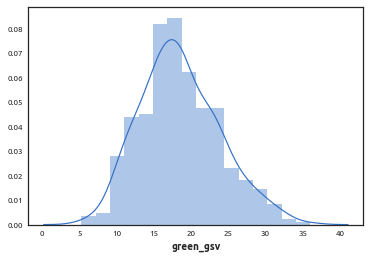

In [101]:
sns.distplot(data_merge['green_gsv'])

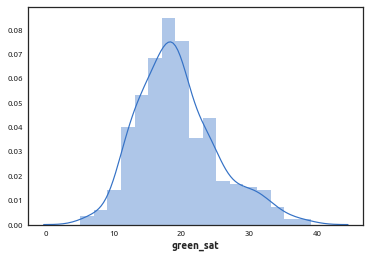

In [102]:
sns.distplot(data_merge['green_sat'])

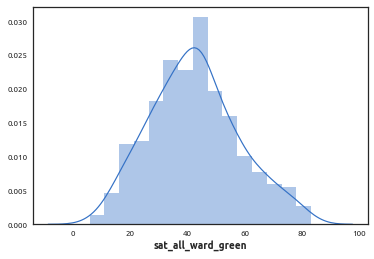

In [103]:
sns.distplot(data_merge['sat_all_ward_green'])

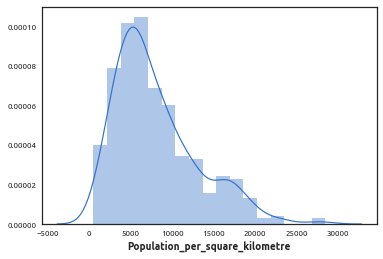

In [104]:
sns.distplot(data_merge['Population_per_square_kilometre'])

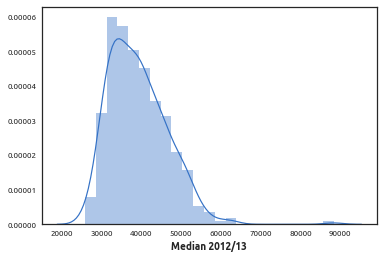

In [105]:
sns.distplot(data_merge['Median 2012/13'])

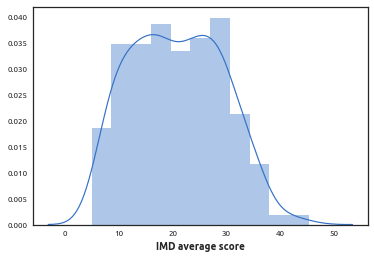

In [106]:
sns.distplot(data_merge['IMD average score'])

In [113]:
features_ztransform = ['green_gsv','green_gsv_unweighted','mean_choice','median_choice','green_sat','green_sat_unweighted','sat_all_ward_green','Population_per_square_kilometre','IMD average score','Median 2012/13','depression_Prevalence']
data_analysis = data_merge[features_ztransform].copy()
for k in features_ztransform:
    data_analysis[k] = (data_analysis[k] - data_analysis[k].mean())/data_analysis[k].std(ddof=0)

In [114]:
data_analysis.head(n=2)

green_gsv  green_gsv_unweighted  mean_choice  median_choice  green_sat  \
0  -1.557015             -1.567001     0.874106       0.891561  -1.240108   
1  -1.604918             -1.645789    -0.320829      -0.481390  -0.099489   

   green_sat_unweighted  sat_all_ward_green  Population_per_square_kilometre  \
0             -1.221944           -0.941864                         0.575967   
1              0.213850            0.225457                         0.012253   

   IMD average score  Median 2012/13  depression_Prevalence  
0           1.233012       -0.716103              -2.312854  
1           1.715286       -0.912722              -0.590382

In [125]:
import statsmodels.api as sm
from scipy.stats import pearsonr
from sklearn import preprocessing
base = ['Population_per_square_kilometre' ,'Median 2012/13']

# interactions = [('green_gsv','green_sat'),('green_gsv','Population_per_square_kilometre'),('Population_per_square_kilometre','green_sat'),('green_gsv','Median 2012/13'),('Median 2012/13','green_sat')]
# terms = []
# for index , i in enumerate(interactions):
#     sampled = data_analysis[[i[0] , i[1]]]
#     normalized_sampled = (sampled-sampled.min())/(sampled.max()-sampled.min())
#     data_analysis[str(i[0])+'*'+str(i[1])] = normalized_sampled[i[0]] * normalized_sampled[i[1]]
#     terms.append(str(i[0])+'*'+str(i[1]))

M1 = base + ['sat_all_ward_green']
M2 = base + ['green_sat_unweighted']
M3 = base + ['green_gsv_unweighted']
M4 = base + ['green_sat']
M5 = base + ['green_gsv']
M5 = base + ['green_sat','green_gsv']
M6 = ['green_sat','green_gsv']



    
    


In [119]:
features = base
Y_dim = ['IMD average score']
Y = np.array(data_analysis[Y_dim].values,dtype=np.float32)
X = np.array(data_analysis[features].values,dtype=np.float32)
X = sm.add_constant(X)
print(features)
model_IMD = sm.OLS(Y, X).fit()
model_IMD.summary(xname=['intercept']+features, yname =  'IMD average score')

['Population_per_square_kilometre', 'Median 2012/13']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      IMD average score   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     406.8
Date:                Tue, 13 Apr 2021   Prob (F-statistic):           4.37e-99
Time:                        22:51:52   Log-Likelihood:                -373.53
No. Observations:                 424   AIC:                             753.1
Df Residuals:                     421   BIC:                             765.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
intercept                        4.082e-10      0.028   1.43e-08      1.000      -0.056       0.056
Population_per_square_kilometre     0.2910      0.029     10.204      0.000       0.235       0.347
Median 2012/13                     -0.7393      0.029    -25.923      0.000      -0.795      -0.683
==============================================================================
Omnibus:                       78.277   Durbin-Watson:                   1.248
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              249.014
Skew:                           0.830   Prob(JB):                     8.46e-55
Kurtosis:                       6.367   Cond. No.                         1.07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [120]:
features = M1
Y_dim = ['IMD average score']
Y = np.array(data_analysis[Y_dim].values,dtype=np.float32)
X = np.array(data_analysis[features].values,dtype=np.float32)
X = sm.add_constant(X)
print(features)
model_IMD = sm.OLS(Y, X).fit()
model_IMD.summary(xname=['intercept']+features, yname =  'IMD average score')

['Population_per_square_kilometre', 'Median 2012/13', 'sat_all_ward_green']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      IMD average score   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     276.2
Date:                Tue, 13 Apr 2021   Prob (F-statistic):           5.81e-99
Time:                        22:52:26   Log-Likelihood:                -370.66
No. Observations:                 424   AIC:                             749.3
Df Residuals:                     420   BIC:                             765.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
intercept                        2.566e-10      0.028   9.07e-09      1.000      -0.056       0.056
Population_per_square_kilometre     0.2301      0.038      6.036      0.000       0.155       0.305
Median 2012/13                     -0.7290      0.029    -25.412      0.000      -0.785      -0.673
sat_all_ward_green                 -0.0922      0.038     -2.394      0.017      -0.168      -0.016
==============================================================================
Omnibus:                       71.891   Durbin-Watson:                   1.283
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              230.389
Skew:                           0.758   Prob(JB):                     9.37e-51
Kurtosis:                       6.278   Cond. No.                         2.29
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [121]:
features = M2
Y_dim = ['IMD average score']
Y = np.array(data_analysis[Y_dim].values,dtype=np.float32)
X = np.array(data_analysis[features].values,dtype=np.float32)
X = sm.add_constant(X)
print(features)
model_IMD = sm.OLS(Y, X).fit()
model_IMD.summary(xname=['intercept']+features, yname =  'IMD average score')

['Population_per_square_kilometre', 'Median 2012/13', 'green_sat_unweighted']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      IMD average score   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     270.6
Date:                Tue, 13 Apr 2021   Prob (F-statistic):           9.95e-98
Time:                        22:52:50   Log-Likelihood:                -373.53
No. Observations:                 424   AIC:                             755.1
Df Residuals:                     420   BIC:                             771.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
intercept                        4.059e-10      0.028   1.42e-08      1.000      -0.056       0.056
Population_per_square_kilometre     0.2914      0.030      9.830      0.000       0.233       0.350
Median 2012/13                     -0.7397      0.030    -24.670      0.000      -0.799      -0.681
green_sat_unweighted                0.0015      0.031      0.047      0.962      -0.060       0.063
==============================================================================
Omnibus:                       78.792   Durbin-Watson:                   1.248
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              251.936
Skew:                           0.834   Prob(JB):                     1.96e-55
Kurtosis:                       6.388   Cond. No.                         1.53
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [122]:
features = M3
Y_dim = ['IMD average score']
Y = np.array(data_analysis[Y_dim].values,dtype=np.float32)
X = np.array(data_analysis[features].values,dtype=np.float32)
X = sm.add_constant(X)
print(features)
model_IMD = sm.OLS(Y, X).fit()
model_IMD.summary(xname=['intercept']+features, yname =  'IMD average score')

['Population_per_square_kilometre', 'Median 2012/13', 'green_gsv_unweighted']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      IMD average score   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     275.7
Date:                Tue, 13 Apr 2021   Prob (F-statistic):           7.25e-99
Time:                        22:53:09   Log-Likelihood:                -370.89
No. Observations:                 424   AIC:                             749.8
Df Residuals:                     420   BIC:                             766.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
intercept                         4.84e-10      0.028   1.71e-08      1.000      -0.056       0.056
Population_per_square_kilometre     0.2701      0.030      9.064      0.000       0.212       0.329
Median 2012/13                     -0.7133      0.031    -23.349      0.000      -0.773      -0.653
green_gsv_unweighted               -0.0736      0.032     -2.297      0.022      -0.137      -0.011
==============================================================================
Omnibus:                       54.759   Durbin-Watson:                   1.286
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              141.448
Skew:                           0.636   Prob(JB):                     1.93e-31
Kurtosis:                       5.528   Cond. No.                         1.66
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [123]:
features = M4
Y_dim = ['IMD average score']
Y = np.array(data_analysis[Y_dim].values,dtype=np.float32)
X = np.array(data_analysis[features].values,dtype=np.float32)
X = sm.add_constant(X)
print(features)
model_IMD = sm.OLS(Y, X).fit()
model_IMD.summary(xname=['intercept']+features, yname =  'IMD average score')

['Population_per_square_kilometre', 'Median 2012/13', 'green_sat']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      IMD average score   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     270.6
Date:                Tue, 13 Apr 2021   Prob (F-statistic):           9.95e-98
Time:                        22:53:26   Log-Likelihood:                -373.53
No. Observations:                 424   AIC:                             755.1
Df Residuals:                     420   BIC:                             771.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
intercept                         4.07e-10      0.028   1.43e-08      1.000      -0.056       0.056
Population_per_square_kilometre     0.2912      0.029      9.910      0.000       0.233       0.349
Median 2012/13                     -0.7395      0.030    -24.685      0.000      -0.798      -0.681
green_sat                           0.0008      0.031      0.027      0.978      -0.060       0.061
==============================================================================
Omnibus:                       78.539   Durbin-Watson:                   1.248
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              250.491
Skew:                           0.832   Prob(JB):                     4.04e-55
Kurtosis:                       6.378   Cond. No.                         1.50
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [124]:
features = M5
Y_dim = ['IMD average score']
Y = np.array(data_analysis[Y_dim].values,dtype=np.float32)
X = np.array(data_analysis[features].values,dtype=np.float32)
X = sm.add_constant(X)
print(features)
model_IMD = sm.OLS(Y, X).fit()
model_IMD.summary(xname=['intercept']+features, yname =  'IMD average score')

['Population_per_square_kilometre', 'Median 2012/13', 'green_sat', 'green_gsv']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      IMD average score   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     208.8
Date:                Tue, 13 Apr 2021   Prob (F-statistic):           2.41e-98
Time:                        22:54:03   Log-Likelihood:                -369.17
No. Observations:                 424   AIC:                             748.3
Df Residuals:                     419   BIC:                             768.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
intercept                        3.662e-10      0.028    1.3e-08      1.000      -0.055       0.055
Population_per_square_kilometre     0.2746      0.030      9.261      0.000       0.216       0.333
Median 2012/13                     -0.7211      0.030    -23.768      0.000      -0.781      -0.661
green_sat                           0.1159      0.050      2.340      0.020       0.019       0.213
green_gsv                          -0.1519      0.051     -2.952      0.003      -0.253      -0.051
==============================================================================
Omnibus:                       69.082   Durbin-Watson:                   1.293
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              213.679
Skew:                           0.738   Prob(JB):                     3.98e-47
Kurtosis:                       6.149   Cond. No.                         3.53
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [126]:
features = M6
Y_dim = ['IMD average score']
Y = np.array(data_analysis[Y_dim].values,dtype=np.float32)
X = np.array(data_analysis[features].values,dtype=np.float32)
X = sm.add_constant(X)
print(features)
model_IMD = sm.OLS(Y, X).fit()
model_IMD.summary(xname=['intercept']+features, yname =  'IMD average score')

['green_sat', 'green_gsv']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      IMD average score   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     41.18
Date:                Tue, 13 Apr 2021   Prob (F-statistic):           4.63e-17
Time:                        22:56:15   Log-Likelihood:                -563.75
No. Observations:                 424   AIC:                             1134.
Df Residuals:                     421   BIC:                             1146.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.514e-09      0.045    3.4e-08      1.000      -0.088       0.088
green_sat      0.0942      0.078      1.206      0.229      -0.059       0.248
green_gsv     -0.4783      0.078     -6.121      0.000      -0.632      -0.325
==============================================================================
Omnibus:                        9.743   Durbin-Watson:                   1.461
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                7.781
Skew:                           0.240   Prob(JB):                       0.0204
Kurtosis:                       2.542   Cond. No.                         3.19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [109]:
import statsmodels.api as sm
from scipy.stats import pearsonr
from sklearn import preprocessing

features = ['green_gsv', 'green_sat','sat_all_ward_green','Population_per_square_kilometre' ,'Median 2012/13']
Y_dim = ['IMD average score']
min_max_scaler = preprocessing.MinMaxScaler() 
Y = np.array(data_merge[Y_dim].values,dtype=np.float32)
X = np.array(data_merge[features].values,dtype=np.float32)

X = min_max_scaler.fit_transform(X)
Y = min_max_scaler.fit_transform(Y)

In [110]:
X = sm.add_constant(X)
print(features)
model_IMD = sm.OLS(Y, X).fit()
model_IMD.summary(xname=['intercept']+features, yname =  'IMD average score')

['green_gsv', 'green_sat', 'sat_all_ward_green', 'Population_per_square_kilometre', 'Median 2012/13']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      IMD average score   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     172.6
Date:                Tue, 13 Apr 2021   Prob (F-statistic):           2.80e-99
Time:                        14:17:52   Log-Likelihood:                 295.60
No. Observations:                 424   AIC:                            -579.2
Df Residuals:                     418   BIC:                            -554.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
intercept                           0.6687      0.031     21.849      0.000       0.609       0.729
green_gsv                          -0.1881      0.062     -3.037      0.003      -0.310      -0.066
green_sat                           0.2335      0.066      3.518      0.000       0.103       0.364
sat_all_ward_green                 -0.1601      0.051     -3.150      0.002      -0.260      -0.060
Population_per_square_kilometre     0.2260      0.047      4.806      0.000       0.134       0.318
Median 2012/13                     -1.2979      0.054    -24.143      0.000      -1.404      -1.192
==============================================================================
Omnibus:                       81.390   Durbin-Watson:                   1.343
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              321.263
Skew:                           0.792   Prob(JB):                     1.73e-70
Kurtosis:                       6.959   Cond. No.                         19.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [111]:
# features = ['green_gsv', 'green_sat','sat_all_ward_green','Population_per_square_kilometre' ,'Median 2012/13']
# features = ['green_gsv', 'green_sat','Population_per_square_kilometre' ,'Median 2012/13']
# features = ['green_gsv', 'sat_all_ward_green' ,'Median 2012/13']
features = ['green_gsv', 'green_sat' ,'Median 2012/13']
Y_dim = ['IMD average score']

interactions = [('green_gsv','green_sat'),('green_gsv','Population_per_square_kilometre'),('Population_per_square_kilometre','green_sat'),('green_gsv','Median 2012/13'),('Median 2012/13','green_sat')]
terms = []
for index , i in enumerate(interactions):
    sampled = data_analysis[[i[0] , i[1]]]
    normalized_sampled = (sampled-sampled.min())/(sampled.max()-sampled.min())
    data_analysis[str(i[0])+'*'+str(i[1])] = normalized_sampled[i[0]] * normalized_sampled[i[1]]
    terms.append(str(i[0])+'*'+str(i[1]))

interaction_terms = terms

# features = features + interaction_terms


print(features)
min_max_scaler = preprocessing.MinMaxScaler() 
Y = np.array(data_analysis[Y_dim].values,dtype=np.float32)
X = np.array(data_analysis[features].values,dtype=np.float32)

# X = min_max_scaler.fit_transform(X)
# Y = min_max_scaler.fit_transform(Y)





['green_gsv', 'green_sat', 'Median 2012/13']


In [112]:
X = sm.add_constant(X)
print(features)
model_IMD_interaction = sm.OLS(Y, X).fit()
model_IMD_interaction.summary(xname=['intercept']+features, yname =  'IMD_z_score')

['green_gsv', 'green_sat', 'Median 2012/13']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            IMD_z_score   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     207.9
Date:                Tue, 13 Apr 2021   Prob (F-statistic):           1.21e-82
Time:                        14:17:52   Log-Likelihood:                -408.65
No. Observations:                 424   AIC:                             825.3
Df Residuals:                     420   BIC:                             841.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept       2.791e-10      0.031   9.02e-09      1.000      -0.061       0.061
green_gsv         -0.2421      0.055     -4.371      0.000      -0.351      -0.133
green_sat          0.1185      0.054      2.183      0.030       0.012       0.225
Median 2012/13    -0.7070      0.033    -21.283      0.000      -0.772      -0.642
==============================================================================
Omnibus:                        9.391   Durbin-Watson:                   0.944
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               11.918
Skew:                           0.218   Prob(JB):                      0.00258
Kurtosis:                       3.696   Cond. No.                         3.40
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""